In [ ]:
!nvidia-smi

Fri Apr 11 15:47:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Step 1: Write CUDA code to a file
code = r'''
#include <iostream>
#include <chrono>
#include <fstream>
#include <cuda_runtime.h>
#include <cstdlib>
#include <ctime>

// Kernel function
__global__ void vecAddKernel(float* A, float* B, float* C, int n) {
    int i = threadIdx.x + blockDim.x * blockIdx.x;
    if (i < n) {
        C[i] = A[i] + B[i];
    }
}

// CPU vector addition
void vecAddCPU(float* A, float* B, float* C, int n) {
    for (int i = 0; i < n; i++) {
        C[i] = A[i] + B[i];
    }
}

int main() {
    std::ofstream log("timing_results.csv");
    log << "n,CPU Time (ms),GPU Time (ms)\n";

    cudaDeviceProp deviceProp;
    cudaGetDeviceProperties(&deviceProp, 0);
    std::cout << "GPU: " << deviceProp.name << "\n";
    std::cout << "Compute Capability: " << deviceProp.major << "." << deviceProp.minor << "\n";

    for (int n = 1000; n <= 10000000; n *= 10) {
        // Seed random number generator
        srand(time(0));

        float* A_h = new float[n];
        float* B_h = new float[n];
        float* C_h = new float[n];
        float* C_cpu = new float[n];

        for (int i = 0; i < n; i++) {
            A_h[i] = static_cast<float>(rand()) / RAND_MAX; // Random float [0,1)
            B_h[i] = static_cast<float>(rand()) / RAND_MAX;
        }

        // GPU timing using cudaEvent
        cudaEvent_t start_gpu, stop_gpu;
        cudaEventCreate(&start_gpu);
        cudaEventCreate(&stop_gpu);

        float *A_d, *B_d, *C_d;
        int size = n * sizeof(float);
        cudaMalloc(&A_d, size);
        cudaMalloc(&B_d, size);
        cudaMalloc(&C_d, size);

        cudaMemcpy(A_d, A_h, size, cudaMemcpyHostToDevice);
        cudaMemcpy(B_d, B_h, size, cudaMemcpyHostToDevice);

        cudaEventRecord(start_gpu);
        vecAddKernel<<<(n + 256 - 1) / 256, 256>>>(A_d, B_d, C_d, n);
        cudaEventRecord(stop_gpu);

        cudaEventSynchronize(stop_gpu);

        cudaMemcpy(C_h, C_d, size, cudaMemcpyDeviceToHost);

        float gpu_time_ms = 0.0f;
        cudaEventElapsedTime(&gpu_time_ms, start_gpu, stop_gpu);

        // Cleanup GPU memory and events
        cudaFree(A_d);
        cudaFree(B_d);
        cudaFree(C_d);
        cudaEventDestroy(start_gpu);
        cudaEventDestroy(stop_gpu);

        // CPU timing
        auto start_cpu = std::chrono::high_resolution_clock::now();
        vecAddCPU(A_h, B_h, C_cpu, n);
        auto end_cpu = std::chrono::high_resolution_clock::now();
        std::chrono::duration<double, std::milli> cpu_time = end_cpu - start_cpu;

        // Log results
        log << n << "," << cpu_time.count() << "," << gpu_time_ms << "\n";

        // Free memory
        delete[] A_h;
        delete[] B_h;
        delete[] C_cpu;
        delete[] C_h;
    }

    log.close();
    return 0;
}

'''

# Step 2: Save to file
with open('vec_add.cu', 'w') as f:
    f.write(code)

# Step 3: Compile using nvcc
# Ref: https://stackoverflow.com/questions/73361454/i-am-getting-zeros-as-a-result-of-vector-additon-in-cuda-and-no-errors
!nvcc -arch=sm_75 vec_add.cu -o vec_add

# Step 4: Run the binary
!./vec_add


GPU: Tesla T4
Compute Capability: 7.5


Index(['n', 'CPU Time (ms)', 'GPU Time (ms)'], dtype='object')


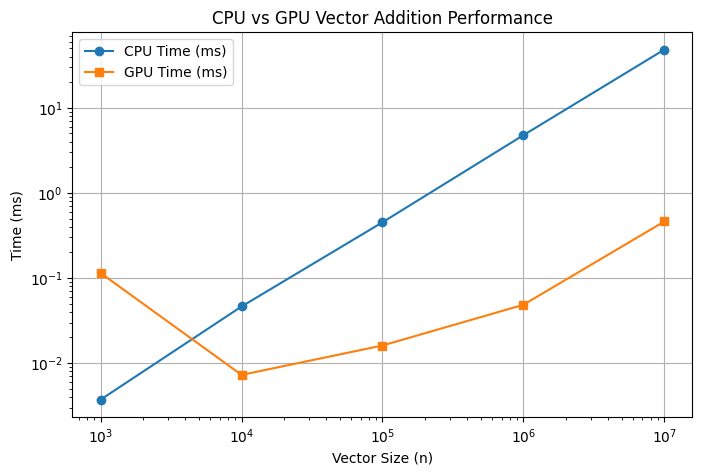

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('timing_results.csv')
df.columns = df.columns.str.strip()
print(df.columns.str.strip())

plt.figure(figsize=(8, 5))
plt.plot(df['n'], df['CPU Time (ms)'], label='CPU Time (ms)', marker='o')
plt.plot(df['n'], df['GPU Time (ms)'], label='GPU Time (ms)', marker='s')
plt.xlabel('Vector Size (n)')
plt.ylabel('Time (ms)')
plt.title('CPU vs GPU Vector Addition Performance')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.show()
